# Monte Carlo Methods

This notebook has implementations of Monte Carlo (MC) algorithms. 

### Part 0: Explore BlackjackEnv

In [53]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [54]:
env = gym.make('Blackjack-v1')

/usr/local/lib/python3.8/dist-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [55]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


The simple code cell below to play Blackjack 5 times with a random policy.  

In [56]:
for i in range(3):
    state = env.reset() #init state
    print('current state is ', state)
    while True:
        action = env.action_space.sample() #select a random action
        print("action is ", "stick" if action == 0 else "hit")
        next_state, reward, done, info = env.step(action) #get an experience (state, reward, and action)
        experience = (next_state, action, reward)
        # print ("next_state is ", next_state)
        if done:
            print("You won! ") if reward > 0 else print("You lost! ")

        state = next_state
        break
        

current state is  (12, 6, False)
action is  hit
You lost! 
current state is  (14, 9, False)
action is  hit
current state is  (15, 6, False)
action is  stick
You won! 


### Part 1: MC Prediction

This section is my implementation of MC prediction (for estimating the action-value function).  

At the beginning, I am investigating a policy where the player (almost) always sticks if the sum of her cards exceeds 18.  In particular, he selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, he selects action `HIT` with 80% probability.  The function `generate_episode_from_stochastic_action` samples an episode using this policy. Each episode has a number of experiences. The episode ends when the `done` variable is set to True by the `env.step(action)` function.

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of experience tuples (state, action, reward) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step. In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [57]:
# Run a policy, extract the experiences, and append to make an episode tuples for offline processing 
def generate_episode_from_stochastic_action(bj_env):
        episode = []
        state = env.reset()
        # from here, we need experience tuples appended into the episode 
        while True:
                probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]  # probability for taking actions 0 or 1 
                action = np.random.choice(np.arange(2), p = probs) # select action to take 0 or 1, with the given probs
                # print ('action is ', action)
                next_state, reward, done, info = bj_env.step(action) 
                experience = (state, action, reward) # this is an experience (set of state, action, and reward). Notice, state is current state. 
                episode.append(experience) # apend the experience in the episode as one step forward
                state = next_state 
                if done:
                        break
        return episode

Execute the code cell below to play Blackjack 3 times with the policy. 

In [58]:
for i in range(3):
    print('episode is ', generate_episode_from_stochastic_action(env))

action is  1
episode is  [((15, 2, False), 1, -1.0)]
action is  0
episode is  [((20, 1, False), 0, -1.0)]
action is  1
episode is  [((16, 7, False), 1, -1.0)]


The mplementation of MC prediction.  In case of the Blackjack environment, either first-visit or every-visit MC prediction techniques are equivalent.

THe algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [23]:
# # Understand the defaultdict and zip(*list) used in the algorithm implementaion

# #Example Python defaultdict does not return a KeyError 
# D = defaultdict(lambda: "Default Value") #lambda: sets a default value for non-existing the dictionary keys
# print (D[100]) #result: Default Value
# #----------------------------------------------

# # The * operator unpacks arguments in a function invocation statement. We want to have a tuple of actions, a tuple of actions, and a tuple of rewards.``
# # Example of building episodes for understanding what zip does.
# states = np.ones(3)
# actions = np.ones(3)*2
# rewards = np.ones(3)*3
# episode = []
# for i in range(3):
#     episode.append((states[i],actions[i],rewards[i]))

# print(episode)
# # Result: [(1.0, 2.0, 3.0), (1.0, 2.0, 3.0), (1.0, 2.0, 3.0)]

# s,a,r = zip(*episode) # unpack the states, actions, and rewards
# print(s)
# print(a)
# print(r)
# # Result: 
# #(1.0, 1.0, 1.0)
# #(2.0, 2.0, 2.0)
# #(3.0, 3.0, 3.0)

Default Value
[(1.0, 2.0, 3.0), (1.0, 2.0, 3.0), (1.0, 2.0, 3.0)]
(1.0, 1.0, 1.0)
(2.0, 2.0, 2.0)
(3.0, 3.0, 3.0)


In [75]:
from tqdm import tqdm # to show progress


def mc_prediction_q(env, num_episodes, generate_episode, gamma=1):
    # 1. initialize empty dictionaries of arrays
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))

    # # 2. loop over episodes and do the following
    # # generate an episode, unpack its components, calc discounts lists
    # # for every state, increment the returns sum to get the cumulative return, increment the visited state-action pair, and average the state-action pair cumulative returns \
    # # to get the action value, which is the state value

    for i_episode in tqdm(range(1, num_episodes+1)):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # generate an episode
        episode = generate_episode(env)

        # unpack the states, actions, and rewards in the returned episode
        states, actions, rewards = zip(*episode)
        print('states: ', states, '\n actions: ',
        actions, '\n rewards: ', rewards)

        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        print('discounts: ', discounts)
        print('-----------------------------------------------------')

        for i, state in enumerate(states):
            print('==new step==')
            print('i is ', i, 'state is ', s,' \nrewards[i:] is', rewards[i:],
                    '\n discounts[:-(1+i)] is', discounts[:-(1+i)])
            print('sum(rewards[i:]*discounts[:-(1+i)]) is ',
                    sum(rewards[i:]*discounts[:-(1+i)]))
                    
            # sum all the (discounted) rewards from this state onward
            returns_sum[state][actions[i]
                               ] += sum(rewards[i:] * discounts[:-(i+1)])
            # N notes that we've been "here" one more time, and then it's easier to see Line 23 as the average of these returns.
            N[state][actions[i]] += 1
            # average of those returns.
            Q[state][actions[i]] = returns_sum[state][actions[i]] / \
                N[state][actions[i]]

    return Q


Obtain the action-value function estimate $Q$, and plot the corresponding state-value function.

 28%|██▊       | 281/1000 [00:00<00:00, 2795.85it/s]

action is  1
action is  1
states:  ((9, 10, False), (15, 10, False)) 
 actions:  (1, 1) 
 rewards:  (0.0, -1.0)
discounts:  [1 1 1]
-----------------------------------------------------
==new step==
i is  0 state is  (1.0, 1.0, 1.0)  
rewards[i:] is (0.0, -1.0) 
 discounts[:-(1+i)] is [1 1]
sum(rewards[i:]*discounts[:-(1+i)]) is  -1.0
==new step==
i is  1 state is  (1.0, 1.0, 1.0)  
rewards[i:] is (-1.0,) 
 discounts[:-(1+i)] is [1]
sum(rewards[i:]*discounts[:-(1+i)]) is  -1.0
action is  1
states:  ((15, 4, False),) 
 actions:  (1,) 
 rewards:  (-1.0,)
discounts:  [1 1]
-----------------------------------------------------
==new step==
i is  0 state is  (1.0, 1.0, 1.0)  
rewards[i:] is (-1.0,) 
 discounts[:-(1+i)] is [1]
sum(rewards[i:]*discounts[:-(1+i)]) is  -1.0
action is  1
states:  ((17, 4, False),) 
 actions:  (1,) 
 rewards:  (-1.0,)
discounts:  [1 1]
-----------------------------------------------------
==new step==
i is  0 state is  (1.0, 1.0, 1.0)  
rewards[i:] is (-1.0,) 
 d

 81%|████████▏ | 813/1000 [00:00<00:00, 2333.51it/s]

action is  1
states:  ((14, 1, False), (15, 1, False)) 
 actions:  (1, 1) 
 rewards:  (0.0, -1.0)
discounts:  [1 1 1]
-----------------------------------------------------
==new step==
i is  0 state is  (1.0, 1.0, 1.0)  
rewards[i:] is (0.0, -1.0) 
 discounts[:-(1+i)] is [1 1]
sum(rewards[i:]*discounts[:-(1+i)]) is  -1.0
==new step==
i is  1 state is  (1.0, 1.0, 1.0)  
rewards[i:] is (-1.0,) 
 discounts[:-(1+i)] is [1]
sum(rewards[i:]*discounts[:-(1+i)]) is  -1.0
action is  1
states:  ((14, 5, False),) 
 actions:  (1,) 
 rewards:  (-1.0,)
discounts:  [1 1]
-----------------------------------------------------
==new step==
i is  0 state is  (1.0, 1.0, 1.0)  
rewards[i:] is (-1.0,) 
 discounts[:-(1+i)] is [1]
sum(rewards[i:]*discounts[:-(1+i)]) is  -1.0
action is  1
action is  1
states:  ((16, 4, False), (19, 4, False)) 
 actions:  (1, 1) 
 rewards:  (0.0, -1.0)
discounts:  [1 1 1]
-----------------------------------------------------
==new step==
i is  0 state is  (1.0, 1.0, 1.0)  
rewa

100%|██████████| 1000/1000 [00:00<00:00, 2421.16it/s]


action is  0
states:  ((15, 10, False),) 
 actions:  (0,) 
 rewards:  (-1.0,)
discounts:  [1 1]
-----------------------------------------------------
==new step==
i is  0 state is  (1.0, 1.0, 1.0)  
rewards[i:] is (-1.0,) 
 discounts[:-(1+i)] is [1]
sum(rewards[i:]*discounts[:-(1+i)]) is  -1.0


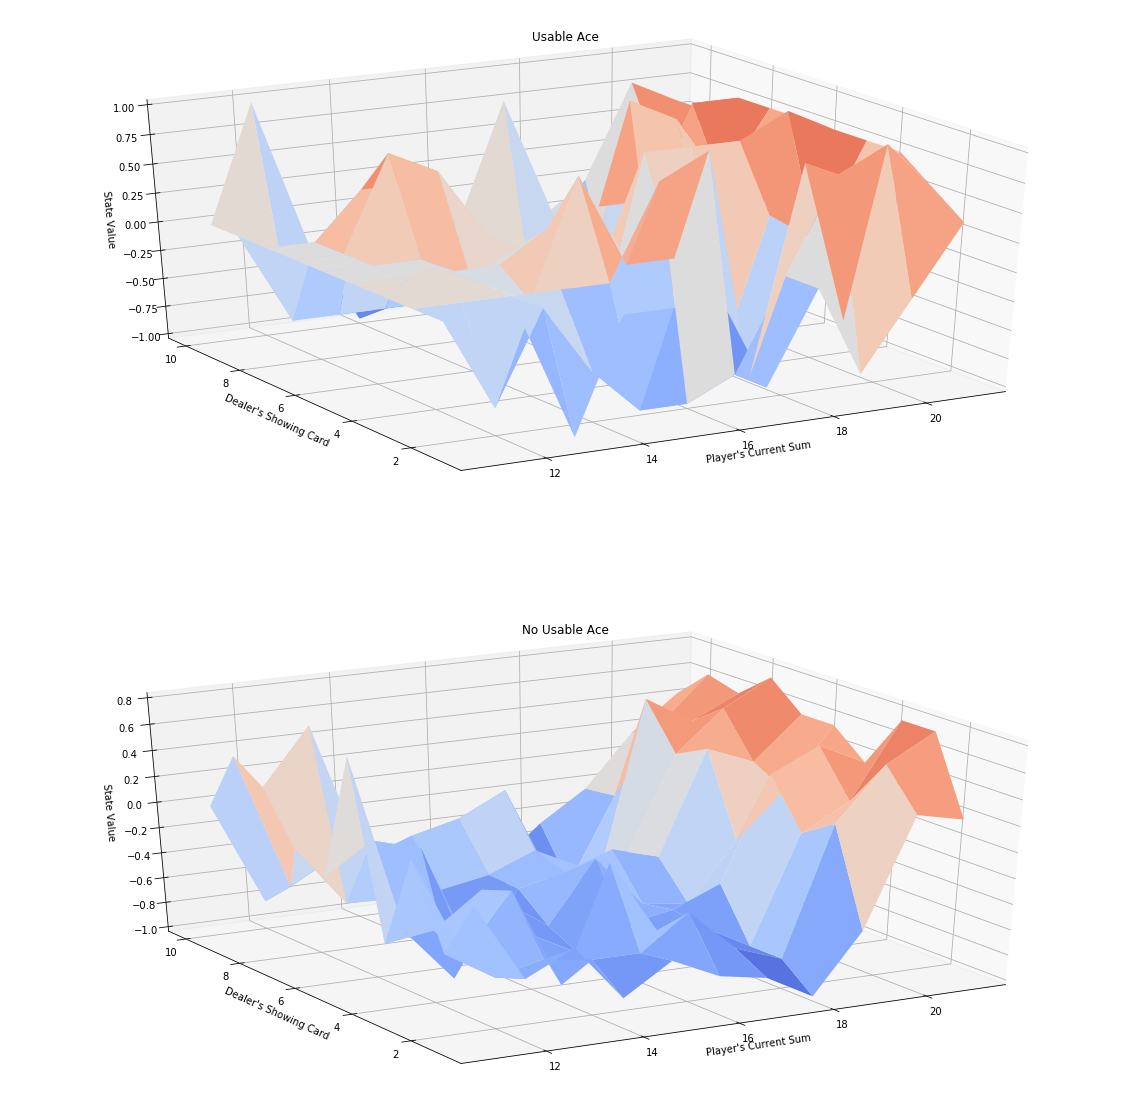

In [76]:
# obtain the action-value function
Q = mc_prediction_q(env, 1000, generate_episode_from_stochastic_action)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [ ]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [ ]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [ ]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.02)

Next, we plot the corresponding state-value function.

In [ ]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

In [ ]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)